In [1]:
import numpy as np
import pandas as pd
import csv
import math
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage
from nltk.corpus import wordnet as wn
sns.set() #get seaborn to work
np.set_printoptions(precision=4, threshold=1000, linewidth=1000, suppress=True, floatmode='fixed')

In [2]:
# Get the polysemy score for each word in a given dataset
def save_wordnet_polysemy(dataset_name):
    wordpair_polysemy = []
    wordpairs = []
    polysemy_address = 'D:\Study and Projects\School Work\Year 25 - PhD 1\Data\\'
    filename = polysemy_address+dataset_name+'_polysemy.txt'
    save_file = open(filename, 'a', encoding='utf-8')

    for word_pair in sim.dataset_storage[dataset_name][0]:
        word_1 = word_pair[0]
        word_2 = word_pair[1]
        both_words = word_1+' '+word_2
        if word_1 in missing_vocab or word_2 in missing_vocab:
            continue
        else:
            polysemy_1 = len(wn.synsets(word_1))
            polysemy_2 = len(wn.synsets(word_2))

            polysemy_total = str(polysemy_1+polysemy_2)
            save_file.writelines(both_words+','+polysemy_total)
            save_file.write('\n')
    save_file.close()
    print('saved')

In [3]:
# Get distance of most similar synset to a given synset
def wordnet_close_synset_score(dataset_name, word_type, excluded_vocab, operation):
    wordnet_sim_storage = []
    for word_pair in sim.dataset_storage[dataset_name][0]:
        word_1 = word_pair[0]
        word_2 = word_pair[1]
        
        synset_sims = [] # loop over all synset pairs for the given word pair
        if word_1 not in excluded_vocab and word_2 not in excluded_vocab:
            for synset_1 in wn.synsets(word_1, word_type):
                for synset_2 in wn.synsets(word_2, word_type):
                    similarity = wn.synset(synset_1.name()).wup_similarity(wn.synset(synset_2.name()))
                    synset_sims.append(similarity)

            if len(synset_sims)==0:
                string = word_1+' '+word_2+','+str(0.5) # average value for missing data
            elif operation=='max':
                string = word_1+' '+word_2+','+str(np.max(synset_sims)) # get most similar synset pair
            elif operation=='mean':
                string = word_1+' '+word_2+','+str(np.mean(synset_sims)) # get average synset similarity
            wordnet_sim_storage.append(string)
    return(wordnet_sim_storage)

# return list of closest matches for 'simverb' vocab
excluded_models = ('wordnet')
excluded_vocab = sim.missing_vocab_set('SimVerb', excluded_models)
out = wordnet_close_synset_score('SimVerb', None, excluded_vocab, 'mean')
np.savetxt("array_mean.txt", np.array(out), fmt='%s')

NameError: name 'sim' is not defined

In [ ]:
# See if there is any improved fit with considering multiple models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Get the similarity vectors for all models
excluded_models = ('wordnet')
vocab_set = 'combined_hq'
excluded_vocab = sim.missing_vocab_set(vocab_set, excluded_models)
full_data = []
for model in sim.models:
    if model=='wordnet': # skip wordnet due to missing words
        continue
    data, model, scale, _, _, _, _ = sim.store_model_dataset_sims(model, vocab_set, excluded_vocab, printing=False, full_import=False)
    full_data.append(model)

# Regression with all models
x = np.array(full_data).transpose()
y = np.array(data)
reg_model = LinearRegression(fit_intercept=True)
reg_model.fit(x, y)
R_square = reg_model.score(x, y)
print('All models')
print(reg_model.coef_)
print(R_square**0.5)

# Regression with two leading models
reg_model_1 = LinearRegression(fit_intercept=True)
reg_vars = [11,8] # choose two models by index
reg_model_1.fit(x[:,reg_vars], y)
R_square = reg_model_1.score(x[:,reg_vars], y)
print('Two models')
print(reg_model_1.coef_)
print(R_square**0.5)

# Regression with just conceptnet
reg_model_1 = LinearRegression(fit_intercept=True)
reg_model_1.fit(x[:,11].reshape(-1, 1), y)
R_square = reg_model_1.score(x[:,11].reshape(-1, 1), y)
print('One model')
print(reg_model_1.coef_)
print(R_square**0.5)

NameError: name 'sim' is not defined

In [475]:
# Classify words using wordnet (not very useful)
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set('MEN', excluded_models)
categories = ('animal.n.01', 'artifact.n.01', 'location.n.01', 'plant.n.02') # categorties to sort words into

for word_pairs in sim.dataset_sim_storage['MEN'].keys():
    word_pairs_list = word_pairs.split()
    word_1 = word_pairs_list[0]
    word_2 = word_pairs_list[1]
    
    if word_1 in excluded_vocab or word_2 in excluded_vocab:
        continue
    
    word_1_class = 0
    for synset in wn.synsets(word_1): # loop over synsets for word
        if match_1==0:
            hypernymns = list(synset.closure(lambda s:s.hypernyms()))
            for ancestor_synset in hypernymns:
                if ancestor_synset.name() in categories:
                    match_1_class=ancestor_synset.name()[0:-5] # set to found category
                    break # stop looking after classificaiton made
                    
        else: # stop looking after classificaiton made
            break
            
    match_2_class = 0
    for synset in wn.synsets(word_1):
        if match_2_class==0:
            hypernymns = list(synset.closure(lambda s:s.hypernyms()))
            for ancestor_synset in hypernymns:
                if ancestor_synset.name() in categories:
                    match_2_class=ancestor_synset.name()[0:-5] # set to found category
        else:
            break
            
    if match_1_class==match_2_class and match_1_class!=0:
        print(word_1+' '+word_2+', '+match_1_class)
    elif match_1_class==match_2_class and match_1_class==0:
        print(word_1+' '+word_2+', something else')
    else:
        print(word_1+' '+word_2+', class mismatch')

NameError: name 'sim' is not defined

In [23]:
class similarity_analysis(object):
    
    def __init__(self):
        # load list of models and databases
        self.models = list(self.model_files.keys())
        self.datasets = list(self.dataset_files.keys())
        
        # generate storage lists and dictionaries for models and databases
        for model in self.models:
            self.model_embed_storage[model] = []
            self.model_sim_storage[model] = {}

        for dataset in self.datasets:
            self.dataset_storage[dataset] = [] 
            self.dataset_sim_storage[dataset] = {} 
            self.missing_vocab_storage[dataset] = {}
       
        # generate vocab set
        self.generate_vocab_set()
        self.import_all_datasets()
        print('Available models:')
        print(self.models)
        print('Available datasets:')
        print(self.datasets)
        return(None)
    
    # Define file location variables
    folder_loc= 'D:/Study and Projects/School Work/Year 25 - PhD 1/Data//'
    model_loc = 'Word Embeddings//'
    dataset_loc = 'Word Similarity Data/Word Similarities Final//'

    model_files = {
                   'CW_vectors':'Collobert and Weston Vectors/embeddings.txt',
                  #'dm_vectors':'Distributional Memory Embeddings/dm_vectors_mini.txt',
                   'dissect_ppmi':'Dissect PPMI Embeddings/ppmi.svd.500_mini.txt',
                   'word2vec_skip':'Word2vec Skipgram CoNLL17/model_mini.txt',
                  #'gensim_skip':'Gensim Skipgram wiki+giga/model_mini.txt',
                   'gensim_BNC':'Gensim Skipgram BNC/model_mini.txt',
                   'gensim_cbow':'Gensim CBoW giga/2010_mini.txt',
                   'glove':'Glove Word Embeddings/glove.840B.300d.mini.txt',
                  #'lexvec':'LexVec Embeddings/lexvec_wiki+newscrawl_300d_mini.txt',
                   'fasttext':'FastText Skipgram wiki+giga/model_mini.txt',
                   'elmo':'Elmo Embeddings/elmo_mini.txt',
                   'conceptnet':'ConceptNet Embeddings/numberbatch-en-mini.txt',
                  #'wordnet':'WordNet Word Embeddings/wn2vec_mini.txt',
                   'bert_large':'bert_large_uncased_mini.txt',
                   'gpt2_large':'gpt2_large_mini.txt',
                   'electra_large':'electra_large_mini.txt',
                   'albert_xxlarge':'albert-xxlarge-v2_mini.txt',
                  #'xlnet_large':'xlnet_large_cased_mini.txt',
                  #'xlm_roberta':'xlm_roberta_large_mini.txt',
                   'ernie':'ernie_2.0_en_mini.txt'
                  #'ernie_context':'ernie_2.0_contextual.txt'
                  #'t5_large':'t5_large_mini.txt',
                  #'bert_context':'simverb_bert_context.txt'
                  }
        
    dataset_files = {
                     'RG65':'EN-RG-65.txt',
                     'YP130':'EN-YP-130.txt',
                    #'MTurk287':'EN-MTurk-287.txt',
                     'MTurk213':'EN-MTurk-213-mod.txt',
                     'MTurk771':'EN-MTurk-771.txt',
                     'WS198':'EN-WS-198-SIM-mod.txt',
                     'WS353':'EN-WS-353-ALL.txt',
                    #'RW':'EN-RW-STANFORD.txt',
                     'RW_mod':'EN-RW-STANFORD-mod.txt',
                     'MEN':'EN-MEN-3k.txt',
                     'SimVerb':'EN-SimVerb-3500.txt',
                     'SimVerb_mod':'EN-SimVerb-3200-mod.txt',  
                     'SimLex':'EN-SIMLEX-999.txt',
                     'SimLexN':'EN-SIMLEX-999-NOUN.txt',
                     'SimLexV':'EN-SIMLEX-999-VERB.txt',
                     'SimLexA':'EN-SIMLEX-999-ADJ.txt',
                    #'Binder14k':'Binder14k.txt',
                     'SemEval2017':'SemEval17.txt',
                     'TR1058':'TR-1058.txt',
                     'combined_full':'combined_dataset_full.txt',
                     'LNCD_5k':'LNCD/LNCD-5k.txt',
                     'LNCD_appliances':'LNCD/LNCD_appliances.txt',
                     'LNCD_birds':'LNCD/LNCD_birds.txt',
                     'LNCD_clothes':'LNCD/LNCD_clothes.txt',
                     'LNCD_fish':'LNCD/LNCD_fish.txt',
                     'LNCD_fruits':'LNCD/LNCD_fruits.txt',
                     'LNCD_insects':'LNCD/LNCD_insects.txt',
                     'LNCD_mammals':'LNCD/LNCD_mammals.txt',
                     'LNCD_music':'LNCD/LNCD_music.txt',
                     'LNCD_occupations':'LNCD/LNCD_occupations.txt',
                     'LNCD_reptiles':'LNCD/LNCD_reptiles.txt',
                     'LNCD_sports':'LNCD/LNCD_sports.txt',
                     'LNCD_tools':'LNCD/LNCD_tools.txt',
                     'LNCD_vegetables':'LNCD/LNCD_vegetables.txt',
                     'LNCD_vehicles':'LNCD/LNCD_vehicles.txt',
                     'LNCD_weapons':'LNCD/LNCD_weapons.txt',
                     'Lee2300':'LBDR/LBDR-2300.txt',
                     'Lee_animals':'LBDR/lee_animals.txt',
                     'Lee_clothing':'LBDR/lee_clothing.txt',
                     'Lee_fish':'LBDR/lee_fish.txt',
                     'Lee_fruit':'LBDR/lee_fruit.txt',
                     'Lee_furniture':'LBDR/lee_furniture.txt',
                     'Lee_kinship':'LBDR/lee_kinship.txt',
                     'Lee_mixture':'LBDR/lee_mixture.txt',
                     'Lee_sport':'LBDR/lee_sport.txt',
                     'Lee_tools':'LBDR/lee_tools.txt',
                     'Lee_vegetables':'LBDR/lee_vegetables.txt',
                     'Lee_vehicles':'LBDR/lee_vehicles.txt',
                     'Lee_weapons':'LBDR/lee_weapons.txt'
                    }
    
    # Define storage dictionaries
    model_embed_storage = {} # for storing the embeddings directly as numpy arrays
    model_sim_storage = {} # for storing pre-computed similarities between word pairs as a dictionary
    dataset_storage = {} # for storing the datasets directly as numpy arrays
    dataset_sim_storage = {} # for storing experimental similarities between word pairs as a dictionary
    
    unique_vocab_set = [] # storage for vocab set
    missing_vocab_storage = {} # storage for missing vocab for each model_dataset pair
    
    # Rare word substitutes
    rare_word_loc = folder_loc+'Corpus Data/Key vocab/Rare_Words_substitutions.csv'
    RW_mod_pd = pd.read_csv(rare_word_loc, index_col=0, header=None, on_bad_lines='skip')
    RW_mod_dict = RW_mod_pd.to_dict()[1] 
    
    
    #### Functions to import vocab, models, and datasets
    
    # Generate full set of unique vocabulary needed to run all the models
    def generate_vocab_set(self):
        full_vocab_set = []
        for dataset in self.datasets:
            if len(self.dataset_storage[dataset])==0: # load dataset if needed
                self.import_dataset(dataset)
            wordset = self.dataset_storage[dataset][0] # get set of words in that dataset
            for wordpair in wordset:
                full_vocab_set.append(wordpair[0])
                full_vocab_set.append(wordpair[1])
        unique_vocab_set = list(set(full_vocab_set)) # unique words only
        unique_vocab_set.sort()
        self.unique_vocab_set = unique_vocab_set
        print('Total tested words:',len(full_vocab_set))
        print('Unique tested words:',len(unique_vocab_set))
        
            
    # Find the combined set of missing vocab over all models for a given dataset
    def missing_vocab_set(self, dataset_name, excluded_models):
        """ string, list_str -> list_str
        Constructs a single consolidated set of missing words for a given dataset, over all the models
        but those in the excluded set. This will be used to conduct a comparison of the models on
        a shared set of vocabulary.
        """
        all_missing = np.array([])
        for model in self.missing_vocab_storage[dataset_name]:
            if model in excluded_models: # skip models to be excluded
                continue
            else:
                model_np = self.missing_vocab_storage[dataset_name][model] # store missing vocab
                all_missing = np.append(all_missing, model_np)
        all_missing = list(set(list(all_missing))) # consolidated set of missing vocab
        return(all_missing)


    # Simple function to print a single model
    def print_model(self, model_name):
        """ string -> None
        Print a summary of the embeddings for a given model.
        """
        if self.model_embed_storage[model_name]==0:
            print('not loaded')
        else:
            display(self.model_embed_storage[model_name][0])
            
            
    # Function to load a specific word embedding model
    def import_model(self, model_name, full_import=False):
        """ string -> None
        Imports an embedding model, storing it in the model_embed_storage dictionary.
        """
        if len(self.model_embed_storage[model_name])==0 or full_import==True: #only if its not already loaded
            
            # open relevant file
            file_loc = self.model_files[model_name]
            filename = self.folder_loc+self.model_loc+file_loc
            with open(filename) as file:
                lines = [line.rstrip('\n') for line in file]

            model_dict = {} # create word dictionary for specific model
            for line in lines:
                word_list = line.split()
                word = word_list[0]
                if full_import==False and word in self.unique_vocab_set: # only  words for testing if full_import==False
                    embedding_list = [float(x) for x in word_list[1:-1]] # store embeddings
                    embedding_np = np.array(embedding_list)
                    model_dict[word] = embedding_np
                elif full_import==True: # this will import all words in the vocab set, not just those for testing
                    embedding_list = [float(x) for x in word_list[1:-1]] # store embeddings
                    embedding_np = np.array(embedding_list)
                    model_dict[word] = embedding_np
                else:
                    continue

            self.model_embed_storage[model_name] = model_dict # store model dictionary in the models dictionary
            print(model_name+' loaded')
            
            
    # Function to import all models into the storage dictionary
    def import_all_models(self, full_import):
        """ None -> None
        Imports all models into the model_embed_storage dictionary.
        """
        for model_name in self.model_embed_storage:
            self.import_model(model_name, full_import)
    
    
    # Function to load word similarity data for specified dataset
    def import_dataset(self, dataset_name):
        """ string -> None
        Imports a dataset, storing a value of the form (list, numpy_array) in the dataset_storage dictionary.
        """
        if len(self.dataset_storage[dataset_name])==0: # if dataset not yet loaded
            file_loc = self.dataset_files[dataset_name]
            filename = self.folder_loc+self.dataset_loc+file_loc
            with open(filename) as file:
                lines = file.readlines()

            wordpairs = [None]*len(lines) # initialise storage
            ratings = [None]*len(lines)
            i=0
            for line in lines:
                line = line.strip() # remove new line chars
                wordpairs[i] = line.split() # split at any whitespace chars
                ratings[i] = float(wordpairs[i][2])
                wordpair_str = wordpairs[i][0]+' '+wordpairs[i][1]
                self.dataset_sim_storage[dataset_name][wordpair_str] = ratings[i] # store experimental data
                i=i+1
            ratings = np.array(ratings)

            self.dataset_storage[dataset_name] = (wordpairs, ratings)

            
    # Function to import all datasets into the storage dictionary
    def import_all_datasets(self):
        """ None -> None
        Imports all datasets into the dataset_embed_storage dictionary.
        """
        for dataset_name in self.dataset_storage.keys():
            self.import_dataset(dataset_name)
    
    
    #### Functions to get word embeddings
    
    # Function to get the embedding for a specific word, given a model
    def get_word_embed(self, model_name, word, full_import):
        """ string, string -> numpy_array, boolean
        Gets the word embedding for a specied model and word.
        """
        self.import_model(model_name, full_import)
        model = self.model_embed_storage[model_name]
        RW_set = self.RW_mod_pd.index.values
        missed = False
                       
        embed_dim = model['man'].shape[0] # get embedding length
        try:
            alt_word = self.RW_mod_dict[word] # alterantive word for RW dataset (similar meaning)
        except:
            alt_word = 0 # no alt word available

        word_list = model.keys() # list of all words in the current model
        if word in word_list:
            word_embed = model[word] # get embedding from pandas array
        elif alt_word!=0 and alt_word in word_list: # try alt word if one is defined
            word_embed = model[alt_word]
        elif word.capitalize() in word_list: # see if capitalised is in there
            word_embed = model[word.capitalize()]
        elif word.lower() in word_list: # see if lower case is in there
            word_embed = model[word.lower()]
        elif word[0:-1] in word_list: # see if non-plural is there
            word_embed = model[word[0:-1]]
        elif word[-2:]=='ed' and word[0:-2] in word_list: # see if non-past tense is there
            word_embed = model[word[0:-2]]
        elif word[-3:]=='ing' and word[0:-3] in word_list: # see if non-infinitive form is there
            word_embed = model[word[0:-3]]
        else: # if the word can't be found in the model
            word_embed = np.random.rand(1,embed_dim)[0] # random embedding
            missed = True

        word_embedding = np.array(word_embed)
        return(word_embedding, missed)
    
    
    # Function to calculate cosine similarity between two embeddings
    def cosine_sim(self, embed_1, embed_2):
        """ numpy_array, numpy_array -> float
        Returns the cosine similarity (-1 to 1) between two embeddings, inputted as vectors.
        """
        if np.dot(embed_1,embed_2) == 0:
            similarity = 0 # don't normalise if similarity is zero
        else:
            similarity = np.dot(embed_1,embed_2)/(np.linalg.norm(embed_1)*np.linalg.norm(embed_2))
            #similarity, _ = spearmanr(embed_1, embed_2)
        return(similarity)
    
    
    # Function to calculate cosine similarity between two words
    def cosine_sim_words(self, word_1, word_2, model_name):
        """ string, string -> float
        Returns the cosine similarity (-1 to 1) between two words, inputted as strings.
        """
        embed_1 = self.get_word_embed(model_name, word_1, False)[0]
        embed_2 = self.get_word_embed(model_name, word_2, False)[0]
        similarity = self.cosine_sim(embed_1, embed_2)
        return(similarity)
      
    
    # Function to compute the similarities of all word pairs from a given database and for a given model
    def compute_model_sims(self, model_name, dataset_name):
        """ string, string -> list_flt
        Returns a list of similarities for all word pairs in a specified dataset, using a specified model.
        """
        self.import_dataset(dataset_name) # load dataset if needed
        dataset_words = self.dataset_storage[dataset_name][0] # word pairs are stored in [0]
        embed_sims = [None]*len(dataset_words)
        missing_vocab = []
        i=0
        for word_pair in dataset_words:
            # get embeddings for both words in word pair
            word_embed_1,miss_1 = self.get_word_embed(model_name, word_pair[0], full_import=False)
            word_embed_2,miss_2 = self.get_word_embed(model_name, word_pair[1], full_import=False)
            if miss_1==True or miss_2==True:
                embed_sims[i] = math.nan # return NaN if either word is missing
            else:
                embed_sims[i] = self.cosine_sim(word_embed_1, word_embed_2)
            
            # keep track of which words are missing
            if miss_1==True:
                missing_vocab.append(word_pair[0])
            if miss_2==True:
                missing_vocab.append(word_pair[1])
            
            # store similarities in dictionary
            word_pair_str = word_pair[0]+' '+word_pair[1] # word pair as string for dictionary storage
            self.model_sim_storage[model_name][word_pair_str] = embed_sims[i] # store model-based similarity             
            i=i+1
                
        dict_key = model_name+'_'+dataset_name # store missing vocab by model and dataset
        self.missing_vocab_storage[dataset_name][model_name] = missing_vocab # add missing words to storage dictionary
        return(embed_sims)
    
    
    # Computes and stores the similarities of all word pairs for all dataset and model combinations
    def compute_all_model_sims(self):
        """ None -> None
        Stores for later use the set of pairwise word similarities for all dataset and model combinations.
        """
        for model_name in self.model_files:
            for dataset_name in self.dataset_files:
                self.compute_model_sims(model_name, dataset_name)
            print(model_name+' similarities computed')
    

    def store_model_dataset_sims(self, model_name, dataset_name, words_to_omit, full_import, printing=False):
        """ string, string, list_str, boolean, boolean -> (list_flt, list_flt, float, list_str, list_str, list_str)
        Constructs a set of words present in both the given model and dataset, returning their cosine similarities for
        the model and dataset, as well as the excluded words, words missing, words included, and wordpairs included.
        """
        # ensure similarities for relevant model and dataset are loaded and computed
        self.import_dataset(dataset_name) # load dataset if needed
        dataset_sims = self.dataset_sim_storage[dataset_name]
        self.import_model(model_name, full_import) # load model if needed
        if self.model_sim_storage[model_name] == {}: # compute model similarities if needed
            self.compute_model_sims(model_name, dataset_name)

        # initialise storage lists and some key variables
        scale = max(list(self.dataset_sim_storage[dataset_name].values())) # get scale of experimental data
        excluded_words = []
        missing_words = []
        included_words = []
        included_model_sims = []
        included_dataset_sims = []
        included_wordpairs = []
        unique_words = []
        
        # loop over all wordpairs in the relevant dataset storage
        for word_pair in self.dataset_sim_storage[dataset_name].keys():
            word_1, word_2 = word_pair.split()
            dataset_similarity = self.dataset_sim_storage[dataset_name][word_pair]
            model_similarity = self.model_sim_storage[model_name][word_pair]
            unique_words.append(word_1)
            unique_words.append(word_2)
            
            if word_1 in words_to_omit or word_2 in words_to_omit: # check for words to omit from analysis
                if word_1 in words_to_omit: 
                    excluded_words.append(word_1)
                if word_2 in words_to_omit:
                    excluded_words.append(word_2)
                
            elif np.isnan(model_similarity): # check for missing words (excluding those omitted above)
                if word_1 not in self.model_embed_storage[model_name]:
                    missing_words.append(word_1)
                elif word_2 not in self.model_embed_storage[model_name]:
                    missing_words.append(word_2)
                    
            else: # only append the word pairs we want and are actually present
                included_words.append(word_1)
                included_words.append(word_2)
                included_dataset_sims.append(dataset_similarity)
                included_model_sims.append(model_similarity)
                included_wordpairs.append(word_pair)
        
        if printing==True: # printing results
            num_unique_words = len(list(set(unique_words)))
            num_included_words = len(set(included_words))
            num_excluded_words = len(set(excluded_words))
            num_missing_words = len(set(missing_words))
            print('evaluating '+model_name+' against '+dataset_name)
            print('included words: '+str(num_included_words)+' out of '+str(num_unique_words))
            print('excluded words: '+str(num_excluded_words)+' out of '+str(num_unique_words))
            print('missing words: '+str(num_missing_words)+' out of '+str(num_unique_words))
        return(included_dataset_sims, included_model_sims, scale, excluded_words, missing_words, included_words, included_wordpairs)
    
    
    # Function to compute the correlation between a given set of model and dataset embedding similarities
    def compute_embed_correls(self, dataset_similarities, model_similarities, scale, printing=False):
        """ list_flt, list_flt, int, boolean -> (list_flt, list_flt, list_flt)
        Computes the pearson_r and spearman_r between word similarities for a dataset and model.
        """
        pearson_r = np.corrcoef(dataset_similarities, model_similarities)[0,1]
        spearman_r, p = spearmanr(dataset_similarities, model_similarities)
        differences = np.array(model_similarities)-np.array(dataset_similarities)/scale # model minus dataset
              
        if printing==True: # printing results
            print('pearson: {:.3f}'.format(pearson_r), '\nspearman: {:.3f}\n'.format(spearman_r))
        return(pearson_r, spearman_r, differences)
    
    
    # Saves a full set of model comparison results to a text file 
    def save_results(self, model_name, dataset_name, word_pairs, differences, data, model):
        results_address = 'D:\Study and Projects\School Work\Year 25 - PhD 1\Data\\'
        filename = results_address+model_name+'_'+dataset_name+'_differences.txt'
        save_file = open(filename, 'a', encoding='utf-8')
        i=0
        for word_pair in word_pairs:
            save_file.writelines(word_pair+','+str(differences[i])+','+str(data[i])+','+str(model[i]))
            save_file.write('\n')
            i=i+1
        save_file.close()
        return('saved')

        
    # Function to compute the correlation between all the models
    def compute_models_corr_matrix(self, vocab_set, excluded_vocab):
        n = len(self.model_files.keys()) # get number of models
        corr_storage = np.zeros((n,n))
        i=0
        j=0

        for model_1_name in list(self.model_files.keys()): # loop over all model pairs
            j=0
            for model_2_name in list(self.model_files.keys()):

                # initialise storage lists and some key variables
                excluded_words = []
                missing_words_model_1 = []
                missing_words_model_2 = []
                included_words = []
                included_model_1_sims = []
                included_model_2_sims = []
                included_wordpairs = []
                unique_words = []

                # loop over all wordpairs in the relevant dataset storage
                for word_pair in self.dataset_sim_storage[vocab_set].keys():
                    word_1, word_2 = word_pair.split()
                    model_1_similarity = self.model_sim_storage[model_1_name][word_pair]
                    model_2_similarity = self.model_sim_storage[model_2_name][word_pair]
                    unique_words.append(word_pair[0])
                    unique_words.append(word_pair[1])

                    if word_1 in excluded_vocab or word_2 in excluded_vocab: # check for words to omit from analysis
                        if word_1 in excluded_vocab: 
                            excluded_words.append(word_1)
                        if word_2 in excluded_vocab:
                            excluded_words.append(word_2)

                    elif np.isnan(model_1_similarity): # check for missing words (excluding those omitted above)
                        if word_1 not in self.model_embed_storage[model_1_name]:
                            missing_words_model_1.append(word_1)
                        elif word_2 not in self.model_embed_storage[model_1_name]:
                            missing_words_model_1.append(word_2)
                    elif np.isnan(model_2_similarity):
                        if word_1 not in self.model_embed_storage[model_2_name]:
                            missing_words_model_2.append(word_1)
                        elif word_2 not in self.model_embed_storage[model_2_name]:
                            missing_words_model_2.append(word_2)

                    else: # only append the word pairs we want and are actually present
                        included_words.append(word_1)
                        included_words.append(word_2)
                        included_model_1_sims.append(model_1_similarity)
                        included_model_2_sims.append(model_2_similarity)
                        included_wordpairs.append(word_pair)
                
                # get counts for included, missing, and excluded words
                num_unique_words = len(set(unique_words))
                num_included_words = len(set(included_words))
                num_excluded_words = len(set(excluded_words))
                num_missing_words = len(set(missing_words_model_1+missing_words_model_2))
                print('evaluating '+model_1_name+' against '+model_2_name)
                print('included words: '+str(num_included_words)+' out of '+str(num_unique_words))
                print('excluded words: '+str(num_excluded_words)+' out of '+str(num_unique_words))
                print('missing words: '+str(num_missing_words)+' out of '+str(num_unique_words))
                
                # calculate correlation between model_1 and model_2
                pearson_r = np.corrcoef(np.array(included_model_1_sims), np.array(included_model_2_sims))[0,1]
                spearman_r, p = spearmanr(np.array(included_model_1_sims), np.array(included_model_2_sims))
                print('pearson: {:.3f}'.format(pearson_r), '\nspearman: {:.3f}\n'.format(spearman_r))
                
                corr_storage[i][j] = spearman_r
                j=j+1
            i=i+1
        return(corr_storage)
       
        
    #### Bootstrapping functions
        
    # Bootstrap a set of draws for a given dataset and model
    def single_bootstrap(self, dataset_similarities, model_similarities, scale):
        n = len(dataset_similarities) # number of word pairs
        rd_vocab_model_sims = np.zeros(n)
        rd_vocab_dataset_sims = np.zeros(n)
        
        # Generate bootstrap sample
        index_list = np.arange(0,n)
        rd_indices = np.random.choice(index_list,n) # get random indices for word pairs in bootstrap
        i=0
        for index in rd_indices:
            rd_vocab = rd_indices[index] # get random vocab pair
            rd_vocab_model_sims[i] = model_similarities[index] # add model similarity
            rd_vocab_dataset_sims[i] = dataset_similarities[index] # add experimental similarity
            i=i+1

        # Calculate correlation and pairwise differences
        pearson_r = np.corrcoef(rd_vocab_dataset_sims, rd_vocab_model_sims)[0,1] # correlation with masks
        spearman_r, p = spearmanr(rd_vocab_dataset_sims, rd_vocab_model_sims)
        differences = (rd_vocab_dataset_sims/scale)-rd_vocab_model_sims
        return(pearson_r, spearman_r, differences)
    
    
    # Compute a series of bootstrap samples for a given model and dataset
    def set_of_bootstraps(self, model_name, dataset_name, words_to_omit, num_samples):
        corr_samples_pearson = []
        corr_samples_spearman = []
        for run in np.arange(0,num_samples):
            data_sims, model_sims, scale, _, _, _, _ = self.store_model_dataset_sims(model_name, dataset_name, words_to_omit, full_import=False, printing=False)
            correlations = self.single_bootstrap(data_sims, model_sims, scale)
            corr_samples_pearson.append(correlations[0])
            corr_samples_spearman.append(correlations[1])
        return(corr_samples_pearson, corr_samples_spearman)
    
    
    # Plot bootstrap results for a given dataset
    def plot_model_bootstraps(self, dataset_name, words_to_omit, excluded_models, num_samples=100):
        mean_correlations = np.array([])
        CI_95_percents = np.array([])
        models_to_plot = [model for model in self.models if model not in list(excluded_models)]
        
        # compute mean and std dev of correlations between all models and specified dataset
        for model_name in models_to_plot:
            pearson_corrs, spearman_corrs = self.set_of_bootstraps(model_name, dataset_name, words_to_omit, num_samples)
            mean_correlations = np.append(mean_correlations, np.mean(spearman_corrs))
            pt_5, pt_95 = np.percentile(spearman_corrs, [5,95]) # get percentiles for 95% CI
            CI_95_percents = np.append(CI_95_percents, (pt_95-pt_5)/2)
            #print('finished '+model_name)
        
        # plot barplot
        fig, ax = plt.subplots(figsize=(30,4))
        ax.bar(x=models_to_plot, #x-coordinates of bars
               height=mean_correlations, #height of bars
               yerr=CI_95_percents, #error bar width
               capsize=6) #length of error bar caps
        plt.show()
        return(mean_correlations, CI_95_percents)

    
    def plot_dendrogram(self, model, word_file):
        # load the list of words to plot a dendrogram for
        file_path = self.folder_loc+'Corpus Data\Key vocab\\'+word_file+'.txt'
        with open(file_path) as file:
             word_list = [line.rstrip('\n').lower() for line in file]
        
        # get the set of embeddings for the word list
        self.import_model(model, full_import=True)
        embeddings_list = []
        for word in word_list:
            embeddings_list.append(self.get_word_embed(model, word, full_import=False)[0])
        embeddings_list = np.array(embeddings_list)    

        # for linkage, complete, weighted, average are the main methods
        Z = linkage(embeddings_list, method='average', metric='cosine', optimal_ordering=True) 
        fig = plt.figure(figsize=(10,30))
        dn = dendrogram(Z, labels=word_list, orientation='right', distance_sort=True, leaf_font_size=12)
        plt.title(word_file+' dendrogram', fontsize=20)
        plt.show()

In [24]:
sim = similarity_analysis()

Total tested words: 88504
Unique tested words: 6186
Available models:
['CW_vectors', 'dissect_ppmi', 'word2vec_skip', 'gensim_BNC', 'gensim_cbow', 'glove', 'fasttext', 'elmo', 'conceptnet', 'bert_large', 'gpt2_large', 'electra_large', 'albert_xxlarge', 'ernie']
Available datasets:
['RG65', 'YP130', 'MTurk213', 'MTurk771', 'WS198', 'WS353', 'RW_mod', 'MEN', 'SimVerb', 'SimVerb_mod', 'SimLex', 'SimLexN', 'SimLexV', 'SimLexA', 'SemEval2017', 'TR1058', 'combined_full', 'LNCD_5k', 'LNCD_appliances', 'LNCD_birds', 'LNCD_clothes', 'LNCD_fish', 'LNCD_fruits', 'LNCD_insects', 'LNCD_mammals', 'LNCD_music', 'LNCD_occupations', 'LNCD_reptiles', 'LNCD_sports', 'LNCD_tools', 'LNCD_vegetables', 'LNCD_vehicles', 'LNCD_weapons', 'Lee2300', 'Lee_animals', 'Lee_clothing', 'Lee_fish', 'Lee_fruit', 'Lee_furniture', 'Lee_kinship', 'Lee_mixture', 'Lee_sport', 'Lee_tools', 'Lee_vegetables', 'Lee_vehicles', 'Lee_weapons']


In [25]:
sim.import_all_models(full_import=False)

CW_vectors loaded
dissect_ppmi loaded
word2vec_skip loaded
gensim_BNC loaded
gensim_cbow loaded
glove loaded
fasttext loaded
elmo loaded
conceptnet loaded
bert_large loaded
gpt2_large loaded
electra_large loaded
albert_xxlarge loaded
ernie loaded


In [26]:
sim.compute_all_model_sims()

CW_vectors similarities computed
dissect_ppmi similarities computed
word2vec_skip similarities computed
gensim_BNC similarities computed
gensim_cbow similarities computed
glove similarities computed
fasttext similarities computed
elmo similarities computed
conceptnet similarities computed
bert_large similarities computed
gpt2_large similarities computed
electra_large similarities computed
albert_xxlarge similarities computed
ernie similarities computed


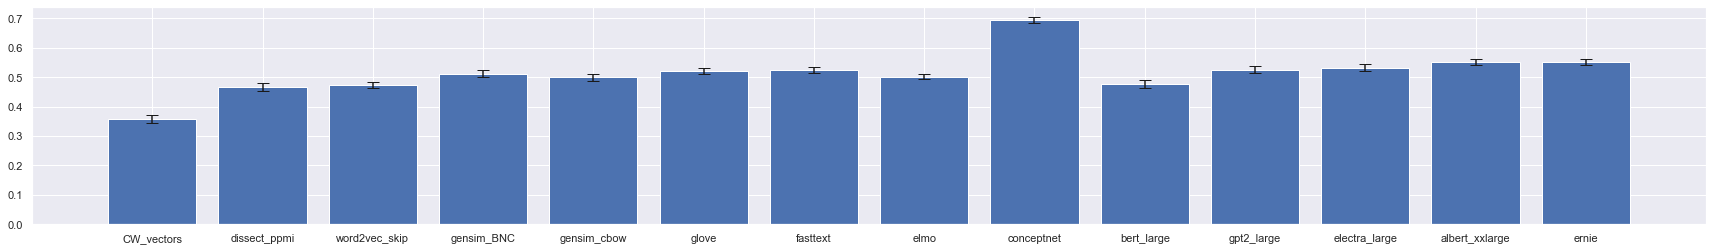

missing words: 767
means: [0.3581 0.4665 0.4742 0.5120 0.4995 0.5224 0.5249 0.5020 0.6936 0.4759 0.5263 0.5330 0.5520 0.5525]
errors: [0.0121 0.0132 0.0113 0.0118 0.0118 0.0102 0.0110 0.0092 0.0107 0.0137 0.0122 0.0106 0.0113 0.0106]


In [36]:
dataset_name = 'combined_full'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

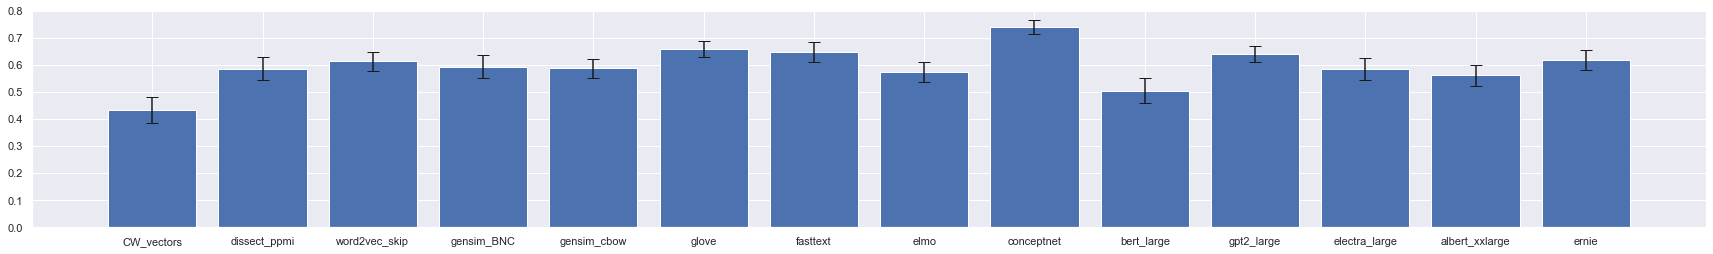

missing words: 41
means: [0.4335 0.5859 0.6137 0.5942 0.5883 0.6584 0.6472 0.5737 0.7397 0.5054 0.6411 0.5848 0.5617 0.6185]
errors: [0.0481 0.0425 0.0352 0.0421 0.0354 0.0300 0.0381 0.0373 0.0259 0.0462 0.0303 0.0393 0.0379 0.0358]


In [24]:
dataset_name = 'TR1058'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

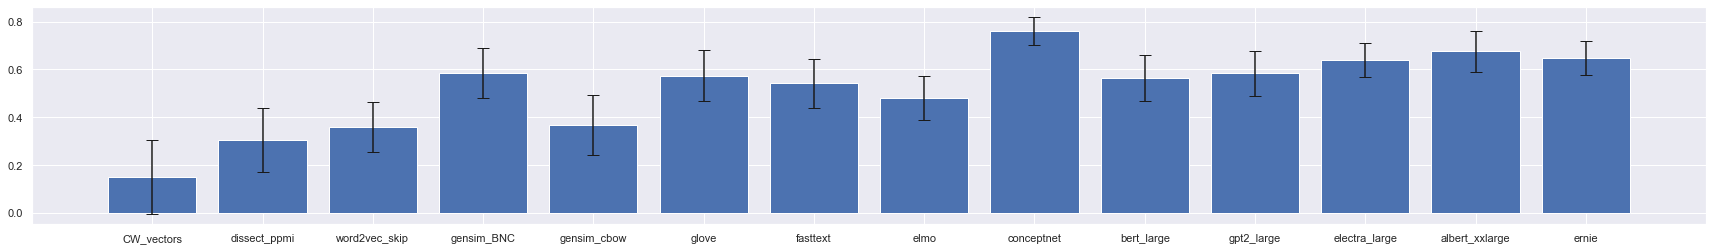

missing words: 1
means: [0.1506 0.3047 0.3580 0.5845 0.3670 0.5728 0.5422 0.4802 0.7610 0.5647 0.5829 0.6391 0.6762 0.6480]
errors: [0.1561 0.1349 0.1050 0.1055 0.1261 0.1064 0.1016 0.0910 0.0592 0.0968 0.0936 0.0716 0.0854 0.0714]


In [32]:
dataset_name = 'YP130'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

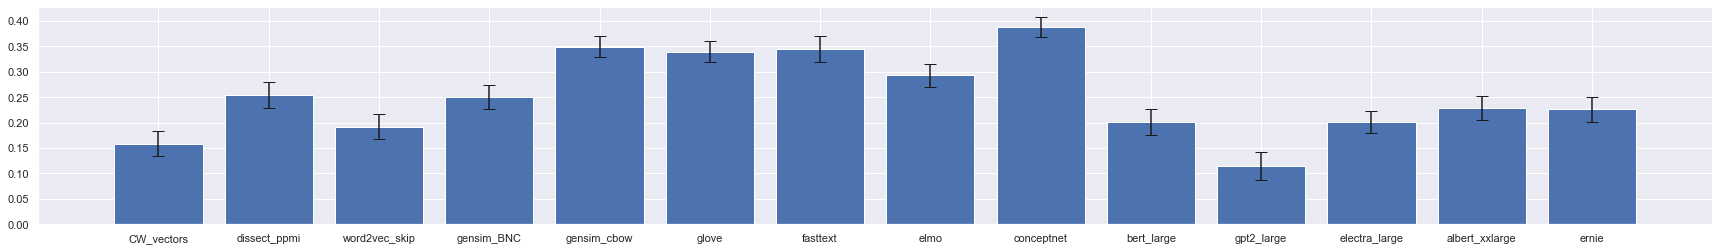

missing words: 40
means: [0.1588 0.2548 0.1919 0.2502 0.3498 0.3399 0.3450 0.2929 0.3879 0.2011 0.1144 0.2006 0.2292 0.2262]
errors: [0.0243 0.0258 0.0247 0.0235 0.0202 0.0209 0.0252 0.0219 0.0198 0.0263 0.0271 0.0219 0.0240 0.0243]


In [28]:
dataset_name = 'LNCD_5k'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

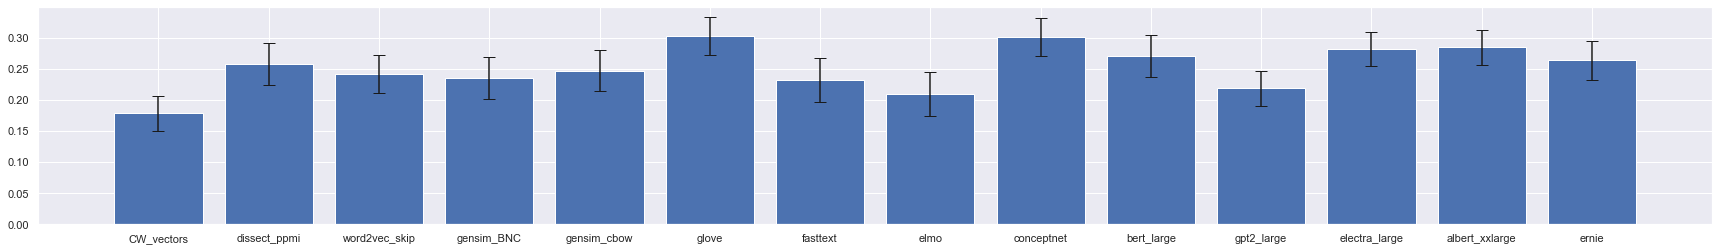

missing words: 9
means: [0.1781 0.2570 0.2412 0.2348 0.2465 0.3020 0.2321 0.2091 0.3010 0.2698 0.2186 0.2820 0.2844 0.2636]
errors: [0.0286 0.0335 0.0299 0.0338 0.0328 0.0307 0.0354 0.0349 0.0310 0.0335 0.0282 0.0272 0.0285 0.0314]


In [31]:
dataset_name = 'Lee2300'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

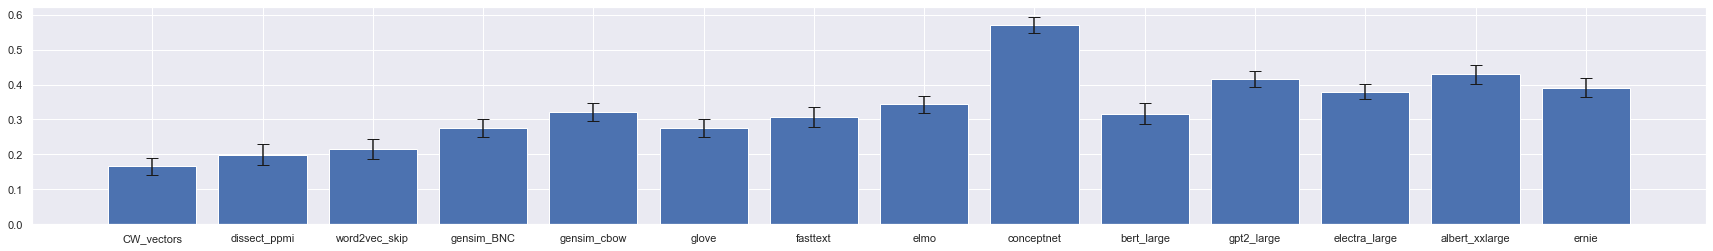

missing words: 20
means: [0.1667 0.1993 0.2150 0.2755 0.3217 0.2766 0.3066 0.3438 0.5697 0.3166 0.4149 0.3793 0.4292 0.3907]
errors: [0.0243 0.0292 0.0296 0.0259 0.0261 0.0261 0.0284 0.0247 0.0232 0.0301 0.0233 0.0218 0.0272 0.0271]


In [27]:
dataset_name = 'SimVerb'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

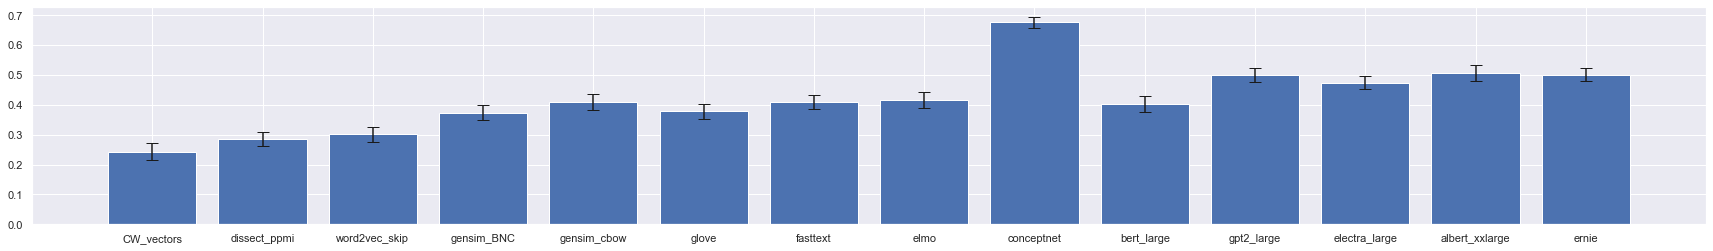

missing words: 17
means: [0.2433 0.2855 0.3007 0.3740 0.4096 0.3781 0.4095 0.4166 0.6757 0.4023 0.4995 0.4739 0.5071 0.5000]
errors: [0.0275 0.0250 0.0254 0.0252 0.0259 0.0258 0.0236 0.0263 0.0176 0.0280 0.0226 0.0224 0.0269 0.0220]


In [26]:
dataset_name = 'SimVerb_mod'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

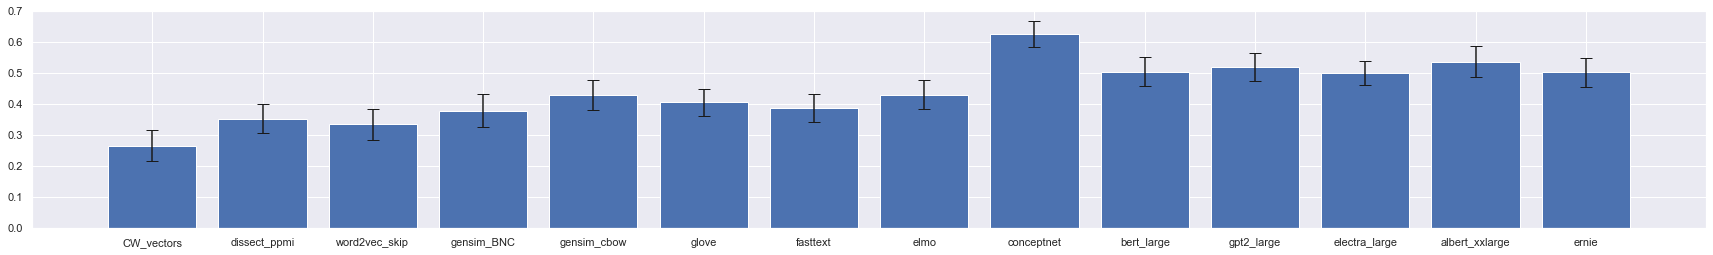

missing words: 5
means: [0.2665 0.3536 0.3349 0.3781 0.4299 0.4060 0.3878 0.4307 0.6263 0.5051 0.5197 0.4999 0.5370 0.5021]
errors: [0.0506 0.0475 0.0492 0.0530 0.0472 0.0427 0.0455 0.0462 0.0412 0.0457 0.0440 0.0395 0.0489 0.0467]


In [27]:
dataset_name = 'SimLex'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

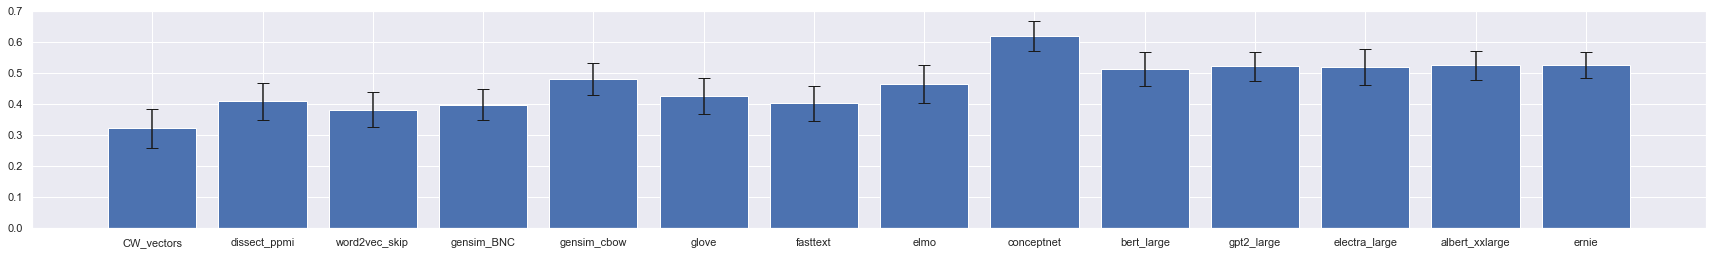

missing words: 3
means: [0.3217 0.4095 0.3828 0.3976 0.4807 0.4274 0.4028 0.4650 0.6203 0.5135 0.5216 0.5209 0.5252 0.5256]
errors: [0.0618 0.0589 0.0559 0.0498 0.0521 0.0575 0.0555 0.0619 0.0474 0.0546 0.0482 0.0583 0.0477 0.0423]


In [29]:
dataset_name = 'SimLexN'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

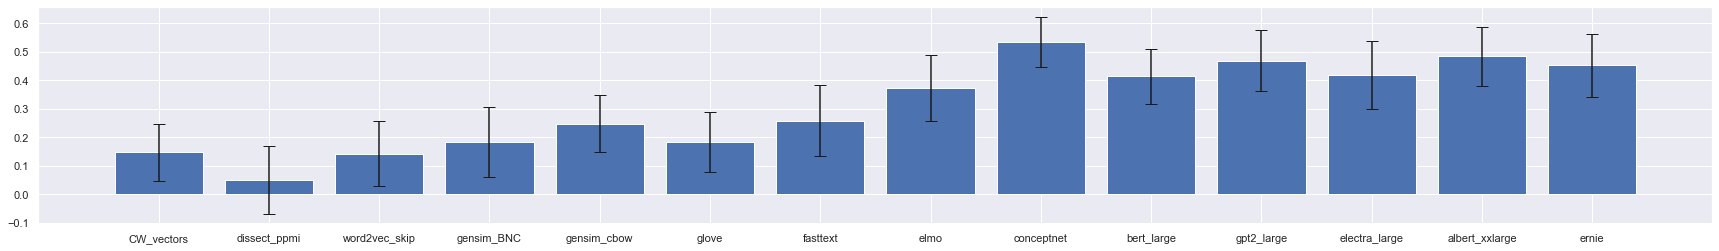

missing words: 2
means: [0.1472 0.0489 0.1426 0.1838 0.2478 0.1844 0.2583 0.3725 0.5344 0.4135 0.4680 0.4195 0.4839 0.4522]
errors: [0.0996 0.1200 0.1130 0.1218 0.1008 0.1056 0.1245 0.1149 0.0889 0.0952 0.1069 0.1194 0.1029 0.1100]


In [30]:
dataset_name = 'SimLexV'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

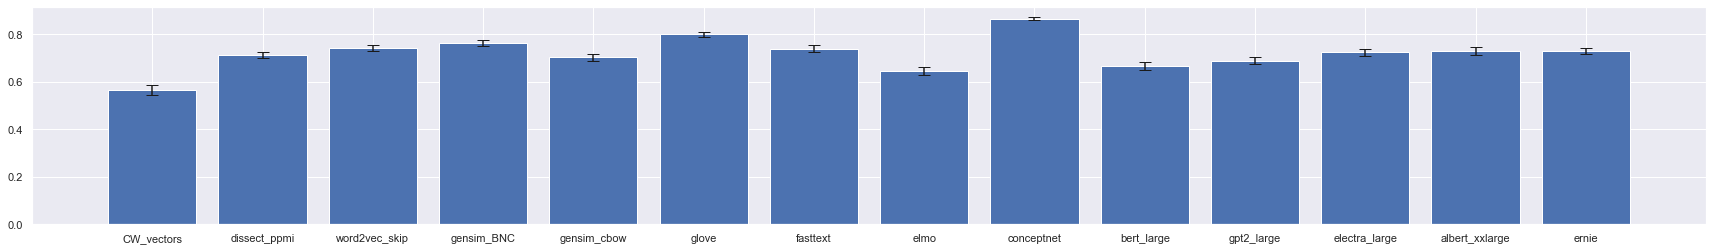

missing words: 8
means: [0.5649 0.7123 0.7406 0.7647 0.7030 0.8002 0.7380 0.6449 0.8659 0.6669 0.6890 0.7232 0.7291 0.7286]
errors: [0.0213 0.0130 0.0128 0.0125 0.0157 0.0106 0.0149 0.0178 0.0060 0.0158 0.0144 0.0130 0.0151 0.0125]


In [29]:
dataset_name = 'MEN'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

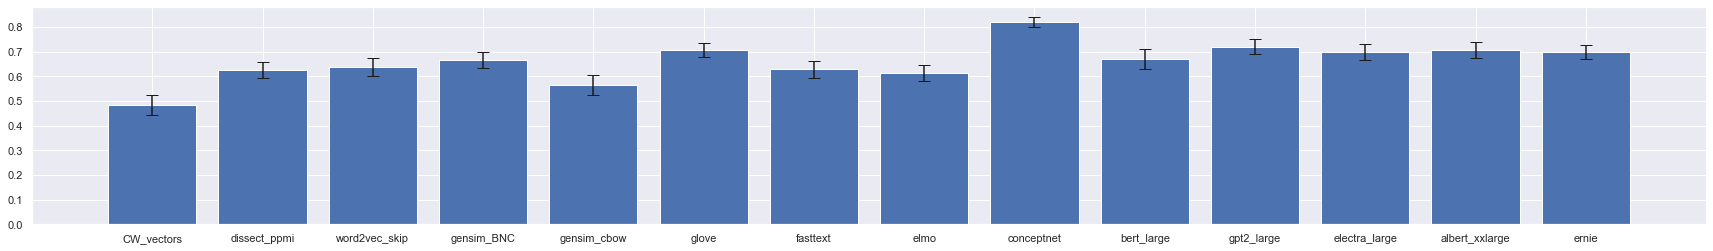

missing words: 6
means: [0.4833 0.6251 0.6377 0.6661 0.5646 0.7078 0.6288 0.6136 0.8199 0.6702 0.7194 0.7000 0.7067 0.6985]
errors: [0.0411 0.0328 0.0364 0.0334 0.0420 0.0283 0.0338 0.0334 0.0199 0.0413 0.0307 0.0328 0.0336 0.0301]


In [601]:
dataset_name = 'MTurk771'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

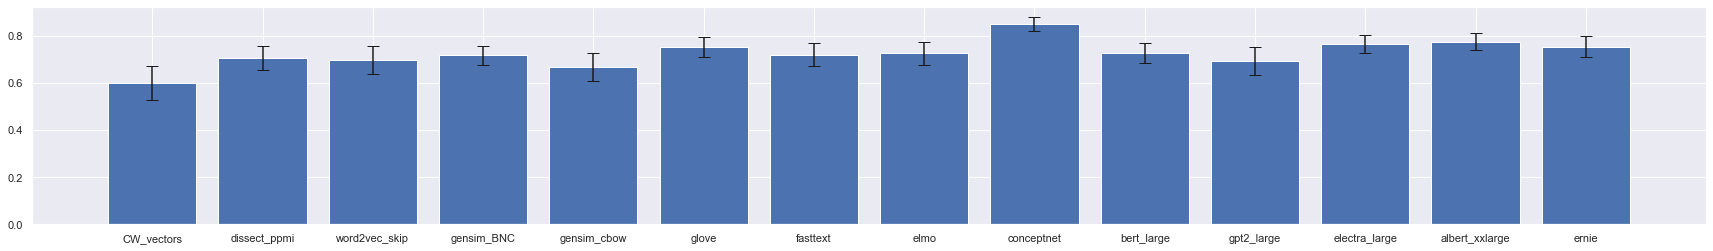

missing words: 33
means: [0.5991 0.7056 0.6971 0.7168 0.6670 0.7528 0.7206 0.7250 0.8496 0.7253 0.6935 0.7661 0.7745 0.7543]
errors: [0.0709 0.0502 0.0598 0.0407 0.0602 0.0436 0.0491 0.0490 0.0295 0.0429 0.0599 0.0380 0.0360 0.0432]


In [33]:
dataset_name = 'SemEval2017'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

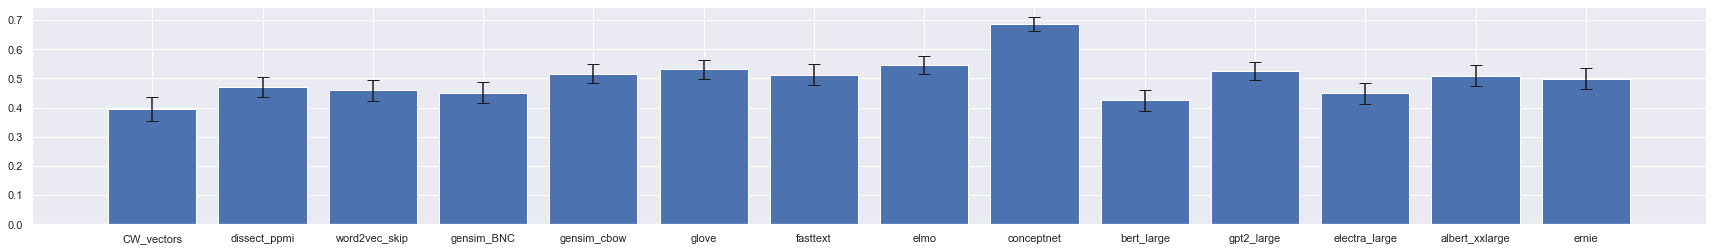

missing words: 651
means: [0.3954 0.4713 0.4589 0.4515 0.5162 0.5308 0.5124 0.5472 0.6872 0.4251 0.5261 0.4497 0.5088 0.4987]
errors: [0.0411 0.0343 0.0354 0.0372 0.0332 0.0328 0.0364 0.0311 0.0229 0.0366 0.0315 0.0359 0.0360 0.0362]


In [31]:
dataset_name = 'RW_mod'
excluded_models = ('wordnet', 'ernie_context')
excluded_vocab = sim.missing_vocab_set(dataset_name, excluded_models)
means, errors = sim.plot_model_bootstraps(dataset_name, excluded_vocab, excluded_models, 100)
print('missing words: '+str(len(excluded_vocab)))
print('means:', means)
print('errors:', errors)

conceptnet loaded


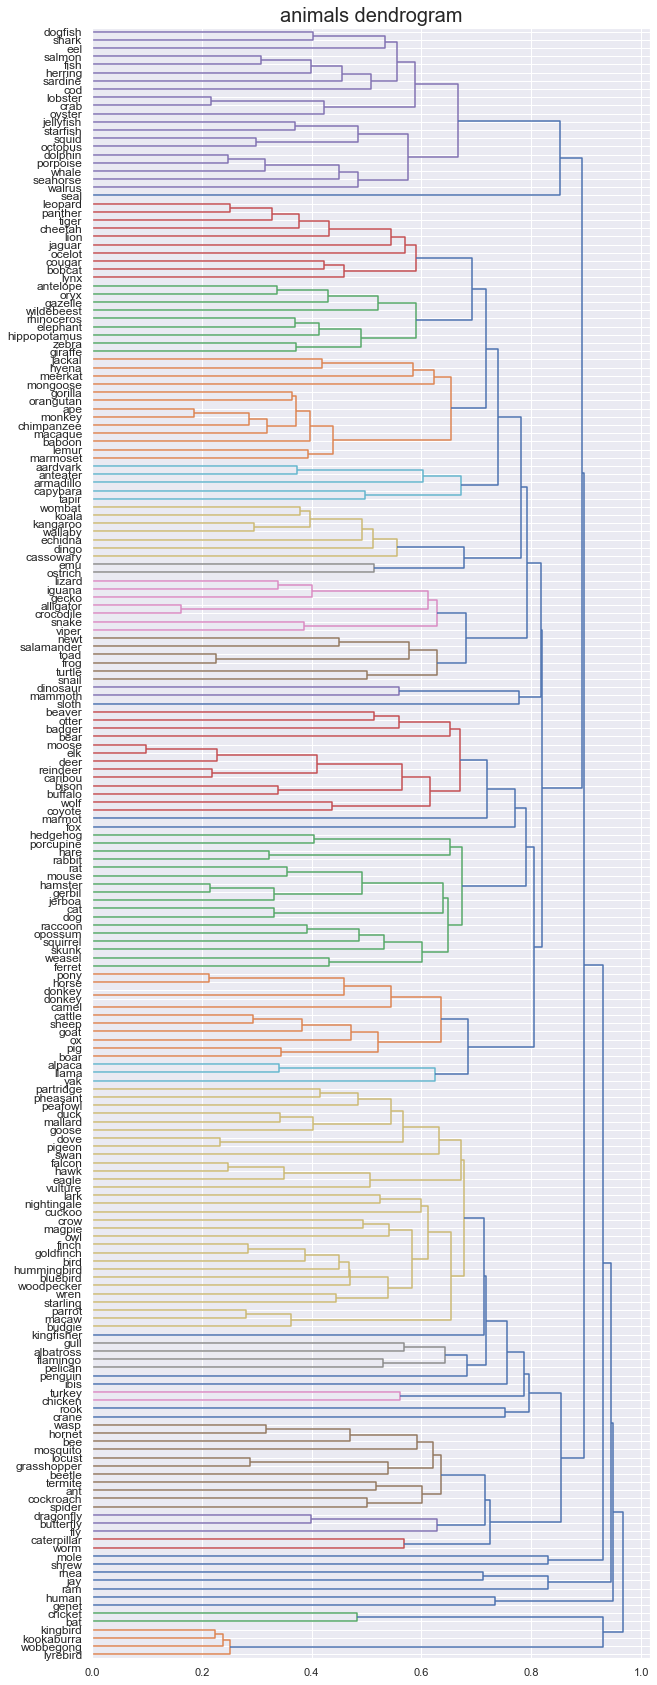

In [22]:
# Plot dendrogram for a given model
sim.plot_dendrogram('conceptnet', 'animals')

In [237]:
# Calculate set of model-model correlations
excluded_models = ('wordnet', 'ernie_context')
vocab_set = 'combined_hq'
excluded_vocab = sim.missing_vocab_set(vocab_set, excluded_models)
correlation_matrix = sim.compute_models_corr_matrix(vocab_set, excluded_vocab)

evaluating CW_vectors against CW_vectors
included words: 3001 out of 5848
excluded words: 74 out of 5848
missing words: 0 out of 5848
pearson: 1.000 
spearman: 1.000

evaluating CW_vectors against dm_vectors
included words: 3001 out of 5848
excluded words: 74 out of 5848
missing words: 0 out of 5848
pearson: 0.399 
spearman: 0.323

evaluating CW_vectors against dissect_ppmi
included words: 3001 out of 5848
excluded words: 74 out of 5848
missing words: 0 out of 5848
pearson: 0.702 
spearman: 0.698

evaluating CW_vectors against word2vec_skip
included words: 3001 out of 5848
excluded words: 74 out of 5848
missing words: 0 out of 5848
pearson: 0.701 
spearman: 0.691

evaluating CW_vectors against gensim_skip
included words: 3001 out of 5848
excluded words: 74 out of 5848
missing words: 0 out of 5848
pearson: 0.665 
spearman: 0.664

evaluating CW_vectors against gensim_BNC
included words: 3001 out of 5848
excluded words: 74 out of 5848
missing words: 0 out of 5848
pearson: 0.588 
spearman:

In [35]:
# Run a single model vs a single dataset
model_name = 'glove'
dataset_name = 'SemEval2017'
excluded_vocab = []
data, model, scale, _, _, words, word_pairs = sim.store_model_dataset_sims(model_name, dataset_name, excluded_vocab, printing=True, full_import=False)
pearson_r, spearman_r, differences = sim.compute_embed_correls(data, model, scale, printing=True)
#save_results(model_name, dataset_name, word_pairs, differences, data, model) # save output

evaluating glove against SemEval2017
included words: 635 out of 635
excluded words: 0 out of 635
missing words: 0 out of 635
pearson: 0.722 
spearman: 0.718



In [10]:
# Run all models against a single dataset
excluded_models = ('wordnet', 'ernie_context')
dataset = 'Lee_mixture'
excluded_vocab = sim.missing_vocab_set(dataset, excluded_models)
for model in sim.models:
    data, model, scale, _, _, _, _ = sim.store_model_dataset_sims(model, dataset, excluded_vocab, full_import=False, printing=True)
    sim.compute_embed_correls(data, model, scale, printing=True)

evaluating CW_vectors against Lee_mixture
included words: 21 out of 21
excluded words: 0 out of 21
missing words: 0 out of 21
pearson: 0.307 
spearman: 0.279

evaluating dissect_ppmi against Lee_mixture
included words: 21 out of 21
excluded words: 0 out of 21
missing words: 0 out of 21
pearson: 0.325 
spearman: 0.213

evaluating word2vec_skip against Lee_mixture
included words: 21 out of 21
excluded words: 0 out of 21
missing words: 0 out of 21
pearson: 0.338 
spearman: 0.253

evaluating gensim_BNC against Lee_mixture
included words: 21 out of 21
excluded words: 0 out of 21
missing words: 0 out of 21
pearson: 0.303 
spearman: 0.235

evaluating gensim_cbow against Lee_mixture
included words: 21 out of 21
excluded words: 0 out of 21
missing words: 0 out of 21
pearson: 0.267 
spearman: 0.213

evaluating glove against Lee_mixture
included words: 21 out of 21
excluded words: 0 out of 21
missing words: 0 out of 21
pearson: 0.332 
spearman: 0.253

evaluating fasttext against Lee_mixture
inclu

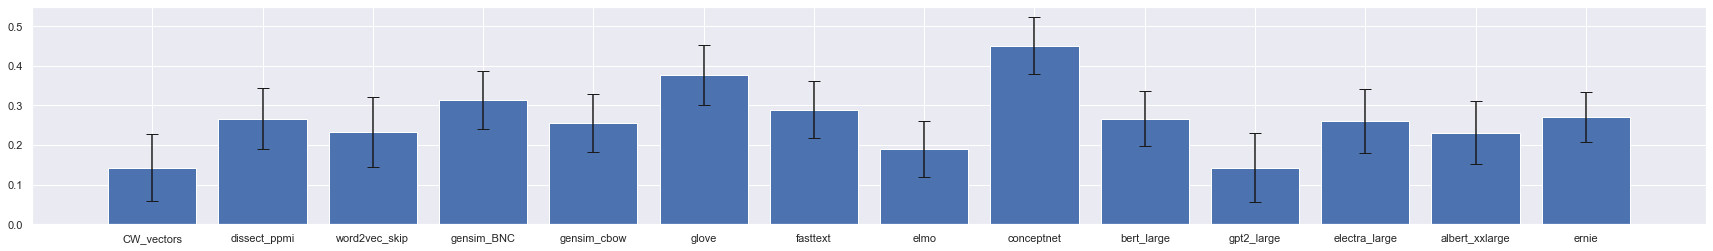

In [22]:
# Compute average correlations over all of the individual LNC mini-datasets, instead of all in one (doesn't make too much difference)

# set key parameters
num_samples = 10
excluded_models = []
dataset_type = 'LNC' #'Lee'

# pick just the desired datasets
needed_datasets = []
for dataset in sim.dataset_storage:
    if dataset[0:3]==dataset_type:
        needed_datasets.append(dataset)

# get set of words to omit
words_to_omit = []
for dataset_name in needed_datasets:
    words = sim.missing_vocab_set(dataset_name, excluded_models)
    for word in words:
        words_to_omit.append(word)

# compute mean and std dev of correlations between all models and specified dataset
all_mean_correlations = np.empty((0,len(models_to_plot)), float)
all_CI_95_percents = np.empty((0,len(models_to_plot)), float)
models_to_plot = [model for model in sim.models if model not in list(excluded_models)]
for dataset_name in needed_datasets:
    mean_correlations = np.array([])
    CI_95_percents = np.array([])
    for model_name in models_to_plot:
        pearson_corrs, spearman_corrs = sim.set_of_bootstraps(model_name, dataset_name, words_to_omit, num_samples)
        mean_correlations = np.append(mean_correlations, np.mean(spearman_corrs))
        pt_5, pt_95 = np.percentile(spearman_corrs, [5,95]) # get percentiles for 95% CI
        CI_95_percents = np.append(CI_95_percents, (pt_95-pt_5)/2)
    all_mean_correlations = np.vstack([all_mean_correlations, mean_correlations])
    all_CI_95_percents = np.vstack([all_CI_95_percents, CI_95_percents])
    
# plot barplot
fig, ax = plt.subplots(figsize=(30,4))
ax.bar(x=models_to_plot, #x-coordinates of bars
       height=np.mean(all_mean_correlations, axis=0), #height of bars
       yerr=np.mean(all_CI_95_percents, axis=0), #error bar width
       capsize=6) #length of error bar caps
plt.show()